In [ ]:
import duckdb

# Conectar ao banco de dados principal
conn = duckdb.connect(database='fineweb.duckdb', read_only=True)

# Executar a consulta modificada
df_training = conn.execute(f"""
WITH sampled_a AS (
    SELECT d.*
    FROM dataset_details d
),
sampled_b AS (
    SELECT d.*
    FROM dataset_details d
)
SELECT
    fn.name AS name,
    a.content AS content1,
    b.content AS content2,
    a.indice - b.indice AS target,
    SIGN(a.indice - b.indice) as teste,
    SIGN(a.indice - b.indice) * (LN(1 + ABS(a.indice - b.indice)) / EXP(1)) AS target_transformed,
    a.content_length AS a_content_length,
    b.content_length AS b_content_length,
    (a.content_length + b.content_length) as contents_length
FROM sampled_a a
JOIN sampled_b b ON a.name_id = b.name_id
JOIN names fn ON fn.name_id = a.name_id
WHERE contents_length < 5000
ORDER BY contents_length DESC
--ORDER BY ((a.content_length + b.content_length) * ((1/(1+ABS(target)))/100) ) DESC
LIMIT 5000 OFFSET 0
""").df()

conn.close()

df_training

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,name,content1,content2,target,teste,target_transformed,a_content_length,b_content_length,contents_length
0,http://www.startuphire.com/job/proposal-writer...,for specific audiences and ensuring alignment ...,for specific audiences and ensuring alignment ...,0,0,0.000000,2451,2451,4902
1,http://ficourseworkpccw.modelbook.us/cultural-...,Cultural challenges of international business ...,Cultural challenges of international business ...,0,0,0.000000,2399,2399,4798
2,https://www.bowlesonline.com/resume/,"complex product portfolio, and ease onboarding...","complex product portfolio, and ease onboarding...",0,0,0.000000,2365,2365,4730
3,http://www.startuphire.com/job/proposal-writer...,for specific audiences and ensuring alignment ...,provide advisory services for developing and c...,1761,1,1.011524,2451,2266,4717
4,http://www.startuphire.com/job/proposal-writer...,provide advisory services for developing and c...,for specific audiences and ensuring alignment ...,-1761,-1,-1.011524,2266,2451,4717
...,...,...,...,...,...,...,...,...,...
4995,https://str.llnl.gov/june-2013/lewis,Google's software development kit for Android ...,could potentially lead to programmatic applica...,3279,1,1.095620,2029,2090,4119
4996,https://str.llnl.gov/june-2013/lewis,could potentially lead to programmatic applica...,Google's software development kit for Android ...,-3279,-1,-1.095620,2090,2029,4119
4997,http://members.ozemail.com.au/~mmichie/aceid.html,the language from around Milingimbi (after Kep...,and are closely associated with the Land. Othe...,3337,1,1.097992,1996,2123,4119
4998,http://members.ozemail.com.au/~mmichie/aceid.html,and are closely associated with the Land. Othe...,the language from around Milingimbi (after Kep...,-3337,-1,-1.097992,2123,1996,4119


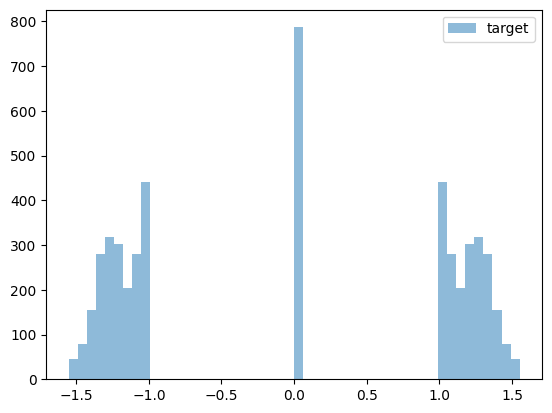

In [4]:
import matplotlib.pyplot as plt

plt.hist(df_training['target_transformed'], bins=50, alpha=0.5, label='target')
plt.legend()
plt.show()

In [ ]:
#  Converter DataLoader para iterador
data_iter = iter(train_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
embeddings.shape

In [1]:
desvios_padrao = 4

import numpy as np

def signed_transform(y):
    """
    Aplica a transformação assinada: ln(1 + |y|) / e¹
    """
    return np.sign(y) * np.log1p(np.abs(y)) / np.exp(1)

def inverse_signed_transform(y_transformed):
    """
    Aplica a transformação inversa: e^(e¹ * |y_transformed|) - 1
    """
    return np.sign(y_transformed) * (np.exp((np.exp(1)) * np.abs(y_transformed)) - 1)

def dissimilaridade(S):
    """
    Calcula a dissimilaridade com ajuste para S igual a zero.
    """
    epsilon = 0
    if S == 0:
        max_x = np.log(np.finfo(np.float32).max)
        epsilon = 1 / (max_x - 1)
    
    return (1 - (S + epsilon)) / (S + epsilon)

In [2]:
# Definir os limites para considerar positivo ou negativo
negative_threshold = signed_transform(-1)/desvios_padrao
positive_threshold = signed_transform(1)/desvios_padrao

print("negative_threshold:", negative_threshold)
print("positive_threshold:", positive_threshold)

negative_threshold: -0.06374864935848838
positive_threshold: 0.06374864935848838


In [3]:
import torch
import gc

if not torch.cuda.is_available():
    print("CUDA is not available. Please ensure you have a compatible GPU and drivers installed.")
else:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")

Using GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [4]:
import torch
import numpy as np
from transformers import AutoTokenizer
import os

# Definir paralelismo corretamente
os.environ["TOKENIZERS_PARALLELISM"] = "true"

class TextToEmbedding:
    def __init__(self, weights_path, num_ids=128256, vector_size=2048, device='cpu'):
        """
        Inicializa a classe TextToEmbedding sem padding fixo.

        Args:
            weights_path (str): Caminho para o arquivo .npy que contém os pesos.
            num_ids (int, opcional): Número total de IDs. Padrão é 128256.
            vector_size (int, opcional): Tamanho de cada vetor de embedding. Padrão é 2048.
            device (str, opcional): Dispositivo para carregar os tensores ('cpu' ou 'cuda'). Padrão é 'cpu'.
        """
		
        self.device = device

        # Carrega o tokenizer sem padding fixo
        self.tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-1B", use_fast=True)
        
        # Carrega os pesos a partir do arquivo .npy
        try:
            weights_np = np.load(weights_path)
            self.weights = torch.from_numpy(weights_np).to(self.device)
        except FileNotFoundError:
            raise FileNotFoundError(f"O arquivo de pesos '{weights_path}' não foi encontrado.")
        except Exception as e:
            raise RuntimeError(f"Erro ao carregar os pesos: {e}")
        
        # Verifica a forma dos pesos
        if self.weights.shape != (num_ids, vector_size):
            raise ValueError(f"O formato do arquivo weights.npy é {self.weights.shape}, mas era esperado {(num_ids, vector_size)}.")

embedding_generator = TextToEmbedding("weights_half.npy", device='cpu')

In [5]:
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np

class SequenceDataset_val(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)

        # Normalizar o target
        self.df['target_norm'] = self.df['target_transformed'] / desvios_padrao
        #self.df['target_norm'] = scaler.transform(self.df[['target_transformed']])

        # Definir o número de elementos originais em cada coluna
        num_content1 = len(self.df['content1'])

        # Combinar as duas colunas de conteúdo em uma lista
        contents = list(self.df['content1']) + list(self.df['content2'])

        # Tokenização combinada
        encoding = embedding_generator.tokenizer(
            contents,
            return_tensors="pt",
            padding=True,  # Padding dinâmico
            truncation=True
        )

        # Separar os encodings de volta para cada conjunto
        encoding1 = {key: encoding[key][:num_content1] for key in encoding.keys()}
        encoding2 = {key: encoding[key][num_content1:] for key in encoding.keys()}

        # Converter para o dispositivo
        input_ids1 = encoding1['input_ids'].to(embedding_generator.device)
        attention_mask1 = encoding1['attention_mask'].to(embedding_generator.device)
        input_ids2 = encoding2['input_ids'].to(embedding_generator.device)
        attention_mask2 = encoding2['attention_mask'].to(embedding_generator.device)

        # Obter embeddings
        embeddings1 = embedding_generator.weights[input_ids1]
        embeddings2 = embedding_generator.weights[input_ids2]

        # Concatenar as duas sequências no eixo 1
        self.embeddings = torch.stack([embeddings1, embeddings2], dim=1)  # (batch_size, 2, seq_length, vector_size)

        # Calcular comprimentos
        lengths1 = attention_mask1.sum(dim=1)
        lengths2 = attention_mask2.sum(dim=1)
        self.lengths = torch.stack([lengths1, lengths2], dim=1)  # (batch_size, 2)

        # Calcular comprimento combinado (exemplo: máximo dos dois)
        combined_lengths = torch.max(lengths1, lengths2)

        # Obter índices ordenados em ordem decrescente de comprimento combinado
        sorted_idx = combined_lengths.argsort(descending=True)

        # Ordenar embeddings, comprimentos e targets
        self.embeddings = self.embeddings[sorted_idx]
        self.lengths = self.lengths[sorted_idx]
        self.targets = torch.tensor(self.df['target_norm'].values, dtype=torch.float16)[sorted_idx]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.lengths[idx], self.targets[idx]

In [6]:
import torch
from torch.utils.data import IterableDataset, DataLoader
import duckdb
from tqdm import tqdm
import pandas as pd

db1_path = 'fineweb.duckdb'
batch_size = 100

class IterableSequenceDataset(IterableDataset):
    def __init__(self, db1_path, batch_size):
        super(IterableSequenceDataset, self).__init__()
        self.db1_path = db1_path
        self.batch_size = batch_size
        self.where = 8000
        self.offset = 0

    def _fetch_data(self, conn):
        query = f"""        
WITH sampled_a AS (
    SELECT d.*
    FROM dataset_details d
),
sampled_b AS (
    SELECT d.*
    FROM dataset_details d
)
SELECT
    fn.name AS name,
    a.content AS content1,
    b.content AS content2,
    a.indice - b.indice AS target,
    SIGN(a.indice - b.indice) * (LN(1 + ABS(a.indice - b.indice))/EXP(1)) AS target_transformed,
    a.content_length AS a_content_length,
    b.content_length AS b_content_length,
    (a.content_length + b.content_length) as contents_length
FROM sampled_a a
JOIN sampled_b b ON a.name_id = b.name_id
JOIN names fn ON fn.name_id = a.name_id
WHERE contents_length < {self.where}
ORDER BY contents_length DESC
LIMIT {self.batch_size} OFFSET {self.offset}
        """
        df = conn.execute(query).df()
        self.offset += 1
        self.where = self.where-self.batch_size
        if self.where < batch_size*3:
            self.where = 5000

        if df.empty:
            return None, None, None  # Indica que não há mais dados

        # Normalizar o target
        df['target_norm'] = df['target_transformed'] / desvios_padrao
        #df['target_norm'] = scaler.transform(df[['target_transformed']])

        # Defina o número de elementos originais em cada coluna
        num_content1 = len(df['content1'])

        # Combinar as duas colunas de conteúdo em uma lista
        contents = list(df['content1']) + list(df['content2'])

        # Tokenização combinada
        encoding = embedding_generator.tokenizer(
            contents,
            return_tensors="pt",
            padding=True,  # Padding dinâmico
            truncation=True
        )

        # Separar os encodings de volta para cada conjunto
        encoding1 = {key: encoding[key][:num_content1] for key in encoding.keys()}
        encoding2 = {key: encoding[key][num_content1:] for key in encoding.keys()}

        # Converter para o dispositivo
        input_ids1 = encoding1['input_ids'].to(embedding_generator.device)
        attention_mask1 = encoding1['attention_mask'].to(embedding_generator.device)
        input_ids2 = encoding2['input_ids'].to(embedding_generator.device)
        attention_mask2 = encoding2['attention_mask'].to(embedding_generator.device)

        # Obter embeddings
        embeddings1 = embedding_generator.weights[input_ids1]
        embeddings2 = embedding_generator.weights[input_ids2]

        # Concatenar as duas sequências no eixo 1
        embeddings = torch.stack([embeddings1, embeddings2], dim=1)  # (batch_size, 2, seq_length, vector_size)

        # Calcular comprimentos
        lengths1 = attention_mask1.sum(dim=1)
        lengths2 = attention_mask2.sum(dim=1)
        lengths = torch.stack([lengths1, lengths2], dim=1)  # (batch_size, 2)

        # Calcular comprimento combinado (máximo dos dois)
        combined_lengths = torch.max(lengths1, lengths2)

        # Obter índices ordenados em ordem decrescente de comprimento combinado
        sorted_idx = combined_lengths.argsort(descending=True)

        # Ordenar embeddings, comprimentos e targets
        embeddings = embeddings[sorted_idx]
        lengths = lengths[sorted_idx]
        targets = torch.tensor(df['target_norm'].values, dtype=torch.float16)[sorted_idx]

        return embeddings, lengths, targets

    def __iter__(self):
        """
        Iterator que gera dados continuamente.

        Yields:
            tuple: (embeddings, lengths, targets) para cada amostra.
        """
        # Estabelecer conexão com DuckDB
        conn = duckdb.connect(database=self.db1_path, read_only=True)
        conn.execute("SET enable_progress_bar=false")

        # Anexar o segundo banco de dados com um alias 'db2'
        #conn.execute(f"ATTACH '{self.db2_path}' AS db2")

        try:
            while True:
                embeddings, lengths, targets = self._fetch_data(conn)
                if embeddings is None:
                    break  # Termina a iteração se não houver mais dados

                yield embeddings, lengths, targets
                
        finally:
            # Garantir que a conexão seja fechada quando o iterador for finalizado
            conn.close()

In [7]:
import pandas as pd

data = {
    'content1': [
        "A tempestade durou várias horas durante a noite.",
        "Ele estudou intensamente para o exame.",
        "A fábrica reduziu a emissão de poluentes.",
        "Maria começou a praticar exercícios regularmente.",
        "O motor do carro parou de funcionar.",
        "Houve uma forte seca na região.",
        "Ela começou a dormir melhor.",
        "A escola adotou uma alimentação saudável.",
        "O projeto teve apoio governamental.",
        "A internet caiu durante a reunião.",
        "Ele começou a economizar dinheiro mensalmente.",
        "A estrada estava em péssimo estado de conservação.",
        "O sistema de ar condicionado foi desligado no escritório.",
        "A empresa investiu em marketing digital.",
        "Ana não revisou o relatório antes de enviar.",
        "As crianças brincaram no parque até tarde.",
        "O curso de capacitação foi oferecido aos funcionários.",
        "Ele comprou um celular novo com câmera de alta qualidade.",
        "A reforma no prédio foi concluída.",
        "A região teve um crescimento populacional rápido.",
        "Carla começou a meditar diariamente.",
        "O atleta intensificou seu treino antes da competição.",
        "O sinal de celular na região foi ampliado.",
        "As temperaturas caíram drasticamente durante o inverno.",
        "Ele não configurou o alarme antes de dormir.",
        "A empresa ofereceu benefícios extras para seus funcionários.",
        "Houve um vazamento de gás na cozinha do restaurante.",
        "A biblioteca da escola foi modernizada com novos livros e tecnologia.",
        "Marcos passou a fazer pausas regulares durante o expediente.",
        "A empresa desenvolveu um aplicativo intuitivo para clientes.",
        "Devido ao aumento das chuvas nas últimas semanas, o nível dos rios subiu rapidamente e ultrapassou a capacidade das barragens.",
        "Ela decidiu começar uma rotina de alimentação balanceada, exercícios físicos regulares e meditação diária para melhorar sua saúde física e mental.",
        "A empresa, que sofria com baixos índices de produtividade, implementou uma nova estratégia de gestão focada no desenvolvimento dos funcionários e na cultura organizacional.",
        "O governo lançou um programa nacional de reciclagem e incentivou a participação ativa dos cidadãos por meio de campanhas de conscientização em escolas, empresas e residências.",
        "Após uma longa estiagem que afetou grande parte do território agrícola do país, o governo implementou um pacote emergencial de apoio aos agricultores, incluindo subsídios e incentivos para a recuperação das lavouras.",
        "Ele deixou o celular carregando a noite inteira sem usar carregadores de segurança e em um local sem ventilação.",
        "A comunidade local se uniu para limpar e revitalizar a praça abandonada, que estava sem manutenção há anos e havia se tornado um ponto de descarte irregular de lixo.",
        "Durante a reforma do prédio, descobriu-se que a estrutura tinha falhas graves, e o prazo para conclusão foi ampliado em seis meses para garantir a segurança.",
        "Um furacão atingiu a região costeira do país, com ventos de mais de 200 km/h, causando destruição em várias cidades e deixando milhares de pessoas desabrigadas.",
        "Ela esqueceu de regar a planta de sua varanda durante o mês todo, e o clima estava seco.",
        "João quebrou o braço jogando futebol.",
        "Devido a uma combinação de fatores climáticos extremos, incluindo ventos fortes e chuvas intensas, a região sofreu graves danos estruturais e interrupção no fornecimento de energia elétrica por vários dias.",
        "Ela esqueceu de levar o guarda-chuva.",
        "A empresa adotou práticas sustentáveis em sua produção, reduzindo o uso de plástico e implementando programas de reciclagem.",
        "A criança se recusou a comer legumes durante toda a semana.",
        "Após anos de pesquisa e desenvolvimento, a equipe científica finalmente descobriu um método eficiente para produzir energia limpa a partir de fontes renováveis.",
        "O café da manhã foi esquecido.",
        "A iniciativa comunitária organizou mutirões de limpeza nas praias locais regularmente durante o verão.",
        "Ele atualizou seu currículo e participou de várias entrevistas de emprego nos últimos meses.",
        "O artista decidiu experimentar novas técnicas em suas pinturas, incorporando elementos digitais e materiais reciclados em suas obras."
    ],
    "content2": [
        "Pela manhã, muitas ruas estavam alagadas.",
        "Conseguiu uma nota alta na prova.",
        "A qualidade do ar na cidade melhorou.",
        "Ela perdeu peso e aumentou sua energia.",
        "Ele teve que chamar o guincho para levar o carro à oficina.",
        "As plantações foram prejudicadas, e a colheita foi menor.",
        "Sua disposição durante o dia melhorou significativamente.",
        "Os alunos passaram a ter mais energia e melhor concentração.",
        "Conseguiu concluir as fases iniciais rapidamente.",
        "A comunicação com a equipe foi interrompida.",
        "Conseguiu juntar uma quantia para uma viagem.",
        "O trânsito ficou mais lento e perigoso para os motoristas.",
        "O ambiente ficou quente e desconfortável para os funcionários.",
        "As vendas aumentaram significativamente.",
        "O documento continha erros e precisou ser corrigido.",
        "Elas ficaram cansadas e dormiram rapidamente ao chegar em casa.",
        "Eles melhoraram suas habilidades e eficiência no trabalho.",
        "Passou a tirar fotos mais nítidas e de melhor resolução.",
        "O local ficou mais seguro e esteticamente agradável.",
        "A demanda por moradias e serviços aumentou consideravelmente.",
        "Ela sentiu uma melhora no seu foco e redução do estresse.",
        "Teve um melhor desempenho e conquistou o primeiro lugar.",
        "A conexão ficou mais estável e acessível para os moradores.",
        "A procura por agasalhos e cobertores aumentou nas lojas.",
        "Acabou se atrasando para o trabalho na manhã seguinte.",
        "A satisfação e motivação dos colaboradores aumentaram.",
        "O local foi evacuado por segurança, e o serviço foi interrompido temporariamente.",
        "Os alunos começaram a frequentá-la mais e a melhorar seu desempenho acadêmico.",
        "Ele se sentiu mais produtivo e menos cansado ao final do dia.",
        "O número de usuários aumentou rapidamente.",
        "Diversas áreas urbanas e rurais foram afetadas por inundações, forçando muitas famílias a deixarem suas casas temporariamente.",
        "Em poucos meses, notou uma grande melhora em sua disposição, concentração e níveis de energia, além de perder peso.",
        "Em menos de um ano, a moral da equipe melhorou, a rotatividade diminuiu, e a produtividade geral aumentou em cerca de 30%.",
        "Como resultado, houve uma redução significativa na quantidade de resíduos sólidos em aterros e uma maior economia de recursos naturais.",
        "Em um ano, a produção agrícola voltou a níveis estáveis, e o impacto econômico negativo foi mitigado, beneficiando a população.",
        "Pela manhã, o dispositivo estava superaquecido e apresentou danos permanentes na bateria, reduzindo sua capacidade de funcionamento.",
        "Com a revitalização, a praça voltou a ser um local de encontro para moradores, e a segurança da área também melhorou.",
        "Apesar do atraso, a reforma resultou em um edifício mais seguro, confortável e com um aumento significativo no valor do imóvel.",
        "A resposta emergencial foi mobilizada rapidamente, com abrigos temporários e ajuda humanitária distribuída para minimizar o impacto nas vítimas.",
        "A planta murchou completamente e, infelizmente, não conseguiu ser recuperada, tendo que ser substituída.",
        "Ele ficou impossibilitado de trabalhar por duas semanas.",
        "A comunidade teve que recorrer a abrigos temporários, e a economia local sofreu uma queda significativa devido à paralisação das atividades comerciais.",
        "Ficou molhada durante o trajeto para o trabalho.",
        "A reputação da empresa melhorou, atraindo consumidores conscientes e aumentando as vendas em 20%.",
        "Sua mãe ficou preocupada com a falta de nutrientes na alimentação dele e decidiu consultar um nutricionista.",
        "Isso resultou na redução significativa das emissões de carbono e no avanço tecnológico sustentável, beneficiando o meio ambiente globalmente.",
        "Ela sentiu fome e falta de energia durante a manhã de trabalho.",
        "As praias ficaram mais limpas e atraentes para turistas, além de promover a conscientização ambiental entre os moradores.",
        "Finalmente recebeu uma oferta de trabalho em uma empresa renomada, melhorando sua estabilidade financeira.",
        "Suas peças ganharam destaque em exposições internacionais, ampliando seu reconhecimento e alcance no mercado de arte."
    ]
}

In [8]:
data = {
    'content1': [
        "The storm lasted several hours during the night.",
        "He studied intensively for the exam.",
        "The factory reduced pollutant emissions.",
        "Maria started exercising regularly.",
        "The car's engine stopped working.",
        "There was a severe drought in the region.",
        "She started sleeping better.",
        "The school adopted a healthy diet.",
        "The project received government support.",
        "The internet went down during the meeting.",
        "He started saving money monthly.",
        "The road was in a terrible state of preservation.",
        "The air conditioning system was turned off in the office.",
        "The company invested in digital marketing.",
        "Ana did not review the report before sending it.",
        "The children played in the park until late.",
        "The training course was offered to the employees.",
        "He bought a new cell phone with a high-quality camera.",
        "The renovation of the building was completed.",
        "The region experienced rapid population growth.",
        "Carla started meditating daily.",
        "The athlete intensified his training before the competition.",
        "The cell signal in the region was expanded.",
        "Temperatures dropped drastically during the winter.",
        "He did not set the alarm before sleeping.",
        "The company offered extra benefits to its employees.",
        "There was a gas leak in the restaurant's kitchen.",
        "The school's library was modernized with new books and technology.",
        "Marcos started taking regular breaks during work hours.",
        "The company developed an intuitive app for customers.",
        "Due to increased rainfall in recent weeks, river levels rose rapidly and exceeded the capacity of the dams.",
        "She decided to start a routine of balanced eating, regular physical exercise, and daily meditation to improve her physical and mental health.",
        "The company, which was suffering from low productivity rates, implemented a new management strategy focused on employee development and organizational culture.",
        "The government launched a national recycling program and encouraged active citizen participation through awareness campaigns in schools, companies, and homes.",
        "After a long drought that affected much of the country's agricultural territory, the government implemented an emergency support package for farmers, including subsidies and incentives for crop recovery.",
        "He left his cell phone charging overnight without using safety chargers and in an unventilated area.",
        "The local community came together to clean and revitalize the abandoned square, which had been unmaintained for years and had become a site for irregular waste disposal.",
        "During the building's renovation, it was discovered that the structure had serious flaws, and the completion deadline was extended by six months to ensure safety.",
        "A hurricane hit the country's coastal region, with winds exceeding 200 km/h, causing destruction in several cities and leaving thousands of people homeless.",
        "She forgot to water her balcony plant all month, and the weather was dry.",
        "João broke his arm playing football.",
        "Due to a combination of extreme weather factors, including strong winds and heavy rains, the region suffered severe structural damage and power supply interruption for several days.",
        "She forgot to take her umbrella.",
        "The company adopted sustainable practices in its production, reducing the use of plastic and implementing recycling programs.",
        "The child refused to eat vegetables throughout the week.",
        "After years of research and development, the scientific team finally discovered an efficient method to produce clean energy from renewable sources.",
        "Breakfast was forgotten.",
        "The community initiative organized beach cleanup drives regularly during the summer.",
        "He updated his resume and participated in several job interviews in recent months.",
        "The artist decided to experiment with new techniques in his paintings, incorporating digital elements and recycled materials into his works."
    ],
    'content2': [
        "In the morning, many streets were flooded.",
        "He achieved a high score on the exam.",
        "The air quality in the city improved.",
        "She lost weight and increased her energy.",
        "He had to call a tow truck to take the car to the garage.",
        "The crops were damaged, and the harvest was smaller.",
        "Her disposition during the day improved significantly.",
        "The students began to have more energy and better concentration.",
        "He managed to complete the initial phases quickly.",
        "Communication with the team was interrupted.",
        "He managed to save an amount for a trip.",
        "Traffic became slower and more dangerous for drivers.",
        "The environment became hot and uncomfortable for the employees.",
        "Sales increased significantly.",
        "The document contained errors and needed to be corrected.",
        "They became tired and slept quickly upon arriving home.",
        "They improved their skills and efficiency at work.",
        "He started taking sharper and higher-resolution photos.",
        "The place became safer and more aesthetically pleasing.",
        "The demand for housing and services increased considerably.",
        "She felt an improvement in her focus and a reduction in stress.",
        "He had better performance and won first place.",
        "The connection became more stable and accessible for residents.",
        "The demand for coats and blankets increased in stores.",
        "He ended up being late for work the next morning.",
        "The satisfaction and motivation of employees increased.",
        "The location was evacuated for safety, and the service was temporarily interrupted.",
        "The students began attending it more and improving their academic performance.",
        "He felt more productive and less tired at the end of the day.",
        "The number of users increased rapidly.",
        "Several urban and rural areas were affected by floods, forcing many families to leave their homes temporarily.",
        "In a few months, she noticed a great improvement in her disposition, concentration, and energy levels, in addition to losing weight.",
        "In less than a year, team morale improved, turnover decreased, and overall productivity increased by about 30%.",
        "As a result, there was a significant reduction in the amount of solid waste in landfills and greater conservation of natural resources.",
        "In one year, agricultural production returned to stable levels, and the negative economic impact was mitigated, benefiting the population.",
        "In the morning, the device was overheated and sustained permanent damage to the battery, reducing its operating capacity.",
        "With the revitalization, the square became a meeting place for residents again, and the area's safety also improved.",
        "Despite the delay, the renovation resulted in a safer, more comfortable building with a significant increase in property value.",
        "The emergency response was mobilized quickly, with temporary shelters and humanitarian aid distributed to minimize the impact on the victims.",
        "The plant withered completely and, unfortunately, could not be recovered, having to be replaced.",
        "He was unable to work for two weeks.",
        "The community had to resort to temporary shelters, and the local economy suffered a significant downturn due to the shutdown of commercial activities.",
        "She got wet during the commute to work.",
        "The company's reputation improved, attracting conscious consumers and increasing sales by 20%.",
        "His mother was worried about the lack of nutrients in his diet and decided to consult a nutritionist.",
        "This resulted in a significant reduction in carbon emissions and sustainable technological advancement, benefiting the global environment.",
        "She felt hungry and lacked energy during the morning of work.",
        "The beaches became cleaner and more attractive to tourists, as well as promoting environmental awareness among residents.",
        "She finally received a job offer from a renowned company, improving her financial stability.",
        "His pieces gained prominence in international exhibitions, expanding his recognition and reach in the art market."
    ]
}

In [9]:
data['target_transformed'] = [signed_transform(len(text)) for text in data['content1']]

df_validation = pd.DataFrame(data)

# Adicionar frases iguais
df_zero = pd.DataFrame({
    'target_transformed': [0] * len(data['target_transformed']),
    'content1': df_validation['content1'],
    'content2': df_validation['content1']
})

df_validation = pd.concat([df_zero, df_validation], ignore_index=True)

# Inverter as colunas content1 e content2
data_reversed = {
    'target_transformed': data['target_transformed'],
    'content1': data['content2'],
    'content2': data['content1'],
}

# Aplicar a transformação ao comprimento do novo content1 (originalmente content2)
data_reversed['target_transformed'] = [-target_transformed for target_transformed in data_reversed['target_transformed']]

df_reversed = pd.DataFrame(data_reversed)

# Concatenar os dois DataFrames
df_validation = pd.concat([df_validation, df_reversed], ignore_index=True)
df_validation

,target_transformed,content1,content2
0,0.000000,The storm lasted several hours during the night.,The storm lasted several hours during the night.
1,0.000000,He studied intensively for the exam.,He studied intensively for the exam.
2,0.000000,The factory reduced pollutant emissions.,The factory reduced pollutant emissions.
3,0.000000,Maria started exercising regularly.,Maria started exercising regularly.
4,0.000000,The car's engine stopped working.,The car's engine stopped working.
...,...,...,...
145,-1.838372,This resulted in a significant reduction in ca...,"After years of research and development, the s..."
146,-1.184158,She felt hungry and lacked energy during the m...,Breakfast was forgotten.
147,-1.634360,The beaches became cleaner and more attractive...,The community initiative organized beach clean...
148,-1.625601,She finally received a job offer from a renown...,He updated his resume and participated in seve...


In [10]:
def collate_train(batch):
    embeddings, lengths, targets = batch[0]
    return embeddings, lengths, targets

training_dataset = IterableSequenceDataset(db1_path,batch_size)
train_dataloader = DataLoader(
  training_dataset, 
  batch_size=1, 
  num_workers=0,
  collate_fn=collate_train,
  pin_memory=False,
  shuffle=False,
  #persistent_workers=True
)

In [11]:
def collate_fn(batch):
    embeddings, lengths, targets = zip(*batch)
    return torch.stack(embeddings).to(torch.float32), torch.stack(lengths), torch.stack(targets).to(torch.float32)

validation_dataset = SequenceDataset_val(df_validation)
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=150,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)

In [12]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class SequenceEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        """
        Inicializa o SequenceEncoder.

        Args:
            input_size (int): Dimensão da entrada de cada elemento da sequência.
            hidden_size (int): Tamanho do estado oculto do LSTM.
            num_layers (int): Número de camadas do LSTM.
        """
        super(SequenceEncoder, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=0.3,
            batch_first=True,
            bidirectional=False
        )

    def forward(self, sequences, lengths):
        """
        Forward pass do SequenceEncoder.

        Args:
            sequences (Tensor): Tensor de sequências com forma [batch_size, seq_len, input_size].
            lengths (Tensor): Tensor de comprimentos com forma [batch_size].

        Returns:
            Tensor: Representação codificada das sequências com forma [batch_size, hidden_size * num_directions].
        """
        # Empacotar as sequências sem exigir ordenação
        packed_seq = rnn_utils.pack_padded_sequence(
            sequences,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False  # Permite sequências não ordenadas
        )

        # Passar pelo LSTM
        packed_output, (hn, cn) = self.lstm(packed_seq)

        hn = hn[-1]  # Forma: [batch_size, hidden_size]

        return hn  # [batch_size, hidden_size * num_directions]

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class SiameseModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, fc_hidden_sizes=[1]):
        """
        Inicializa o SiameseModel.

        Args:
            input_size (int): Dimensão da entrada de cada elemento da sequência.
            hidden_size (int): Tamanho do estado oculto do LSTM.
            num_layers (int): Número de camadas do LSTM.
            fc_hidden_sizes (list of int): Tamanhos das camadas ocultas totalmente conectadas adicionais.
        """
        super(SiameseModel, self).__init__()
        self.encoder = SequenceEncoder(input_size, hidden_size, num_layers)

        # Camadas totalmente conectadas para combinar as duas representações
        self.fc_layers = nn.ModuleList()
        input_dim = hidden_size * 2  # Considerando bidirecional, se aplicável

        for hidden_size_fc in fc_hidden_sizes:
            self.fc_layers.append(nn.Linear(input_dim, hidden_size_fc))
            self.fc_layers.append(nn.ReLU())
            input_dim = hidden_size_fc

        self.output_layer = nn.Linear(input_dim, 1)

    def forward(self, sequences, lengths):
        """
        Forward pass para a rede Siamese.

        Args:
            sequences (Tensor): Tensor de embeddings com forma [batch_size, 2, seq_len, input_size].
            lengths (Tensor): Tensor de comprimentos com forma [batch_size, 2].

        Returns:
            Tensor: Predições de saída com forma [batch_size].
        """
        # Dividir as sequências e os comprimentos para ambos os inputs
        seq1 = sequences[:, 0, :, :]  # Forma: [batch_size, seq_len, input_size]
        len1 = lengths[:, 0]           # Forma: [batch_size]
        out1 = self.encoder(seq1, len1)  # Forma: [batch_size, hidden_size * num_directions]

        seq2 = sequences[:, 1, :, :]  # Forma: [batch_size, seq_len, input_size]
        len2 = lengths[:, 1]           # Forma: [batch_size]
        out2 = self.encoder(seq2, len2)  # Forma: [batch_size, hidden_size * num_directions]

        # Combinar as duas representações
        combined = torch.cat([out1, out2], dim=1)  # Forma: [batch_size, hidden_size * num_directions * 2]

        # Passar pelas camadas totalmente conectadas com ativação não-linear e dropout
        x = combined
        for layer in self.fc_layers:
            x = layer(x)

        out = self.output_layer(x)  # Forma: [batch_size, 1]

        return out.squeeze(1)  # Forma: [batch_size]

In [15]:
import pytorch_lightning as pl
from torch.optim.lr_scheduler import OneCycleLR

limit_train_batches=20
max_epochs=10

class CustomHuberLoss(nn.Module):
	def __init__(self, delta=1.0):
		super(CustomHuberLoss, self).__init__()
		self.delta = delta
		self.loss = nn.HuberLoss(delta=delta) # torch.nn.MSELoss()

	def forward(self, output, target):
		# Verificar os sinais de output e target usando os limites fornecidos
		output_sign = (output <= negative_threshold).float() - (output >= positive_threshold).float()
		target_sign = (target <= negative_threshold).float() - (target >= positive_threshold).float()

		# Calcular a perda Huber normal
		loss = self.loss(output, target)

		# Verificar se o sinal de output é diferente de target
		sign_diff = (output_sign != target_sign).float()

		# Se os sinais forem diferentes, multiplicar a perda por 2
		adjusted_loss = loss * (1 + sign_diff) 

		return adjusted_loss.mean()

class SiameseModel_Lightning(pl.LightningModule):
	def __init__(self, input_size=2048, hidden_size=16, num_layers=8, lr=1e-3, max_lr=1e-2):
		super(SiameseModel_Lightning, self).__init__()
		self.save_hyperparameters()

		# Instanciar o modelo modificado
		self.model = SiameseModel(
			input_size=input_size,
			hidden_size=hidden_size,
			num_layers=num_layers,
			#fc_hidden_sizes=[hidden_size - i for i in range(hidden_size)]
		)

		# Função de perda
		self.criterion = CustomHuberLoss()

	def forward(self, sequences, lengths):
		return self.model(sequences, lengths)
	
	def training_step(self, batch):
		embeddings, lengths, targets = batch  # embeddings: (batch_size, 2, seq_len, vector_size)
		embeddings = embeddings.to(self.device)
		lengths = lengths.to(self.device)
		targets = targets.to(self.device)

		# Passagem para frente
		outputs = self(embeddings, lengths)  # (batch_size,)

		# Computar a perda
		loss = self.criterion(outputs, targets)

		# Logar a perda de treinamento
		self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

		# Obter a taxa de aprendizado atual do primeiro grupo de parâmetros
		lr = self.optimizers().param_groups[0]['lr']
		# Logar a taxa de aprendizado
		self.log('lr', lr, on_step=True, on_epoch=False, prog_bar=True, logger=True)

		# Clear variables
		del embeddings, lengths, targets, outputs
		gc.collect()
		torch.cuda.empty_cache()
		return loss

	def validation_step(self, batch):
		embeddings, lengths, targets = batch
		embeddings = embeddings.to(self.device)
		lengths = lengths.to(self.device)
		targets = targets.to(self.device)

		# Passagem para frente
		outputs = self(embeddings, lengths)

		# Computar a perda
		loss = self.criterion(outputs, targets)

		# Logar a perda de validação
		self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

	def configure_optimizers(self):
		# Otimizador Adam
		optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

		# Configuração do OneCycleLR
		scheduler = OneCycleLR(
			optimizer,
			max_lr=self.hparams.max_lr,
			total_steps=(max_epochs * limit_train_batches),
			anneal_strategy='cos',
			pct_start=0.3,
			cycle_momentum=True,
			base_momentum=0.85,
			max_momentum=0.95,
		)

		# Retornar otimizador e scheduler com interval definido para 'step'
		return {
			'optimizer': optimizer,
			'lr_scheduler': {
				'scheduler': scheduler,
				'interval': 'step',      # Atualiza a cada passo
				'frequency': 1,          # Frequência de atualização
			}
		}

In [16]:
from pytorch_lightning.loggers import TensorBoardLogger

# Instanciando o TensorBoardLogger
tensorboard_logger = TensorBoardLogger('tb_logs', name='model_name')

In [17]:
model = SiameseModel_Lightning()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [ ]:
#model = SiameseModel_Lightning.load_from_checkpoint('./checkpoints/best-checkpoint-v11.ckpt')

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

# Definir callbacks, por exemplo, ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=max_epochs,
    precision=16,
    #gradient_clip_val=1.0,
    accelerator='auto',
    devices='auto',
    callbacks=[checkpoint_callback],
    accumulate_grad_batches=20,
    deterministic=False,
    limit_train_batches=limit_train_batches,
    log_every_n_steps=limit_train_batches,
    profiler="simple",
    logger=tensorboard_logger
)

# Iniciar o treinamento
trainer.fit(
    model,
    train_dataloaders=train_dataloader, #IterableDataset
    val_dataloaders=validation_dataloader #Dataset
)

/home/jadson/anaconda3/envs/pytorch/lib/python3.12/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/jadson/anaconda3/envs/pytorch/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/jadson/Documentos/Tempo-nas-Narrativas/checkpoints exists and is not empty.
LOCAL_RANK: 0 - 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/jadson/anaconda3/envs/pytorch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (150x4096 and 32x1)

In [20]:
#  Converter DataLoader para iterador
data_iter = iter(validation_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
print("validation_dataloader",embeddings.shape,lengths.shape,targets.shape)

# Ensure your model and inputs are in float16 if using AMP
#model = model.half()
#embeddings = embeddings.half()
#targets = targets.half()

embeddings = embeddings.to(torch.float32).to('cuda')
lengths = lengths.to(torch.int64).to('cuda')
targets = targets.to(torch.float32).to('cuda')

model.to('cuda')
model.eval()

# Realizar a previsão
with torch.no_grad():
	output = model(embeddings, lengths)

# Verificar os sinais de output e target usando os limites fornecidos
output_sign = (output <= negative_threshold).float() - (output >= positive_threshold).float()
target_sign = (targets <= negative_threshold).float() - (targets >= positive_threshold).float()

# Calcular as correspondências
matches = (output_sign == target_sign)

# Calcular a precisão média
accuracy = matches.float().mean()
print(f"Acurácia: {accuracy:.4f}")

# Imprimir os resultados da previsão junto com os valores target
for i, (pred, target) in enumerate(zip(output, targets)):
    print(f"Par {i+1}: {inverse_signed_transform(pred.item()*desvios_padrao):.4f} Target: {inverse_signed_transform(target.item()*desvios_padrao):.4f}")

validation_dataloader torch.Size([150, 2, 33, 2048]) torch.Size([150, 2]) torch.Size([150])
Acurácia: 0.3333
Par 1: -276.4671 Target: 0.0000
Par 2: -276.4659 Target: 169.1358
Par 3: -276.4662 Target: -203.1998
Par 4: -276.4659 Target: -169.1358
Par 5: -276.4672 Target: 0.0000
Par 6: -276.4669 Target: 203.1998
Par 7: -276.4701 Target: 0.0000
Par 8: -276.4672 Target: 180.8098
Par 9: -276.4673 Target: -180.8098
Par 10: -276.4679 Target: 0.0000
Par 11: -276.4676 Target: 161.9527
Par 12: -276.4691 Target: 0.0000
Par 13: -276.4679 Target: 156.1121
Par 14: -276.4686 Target: -156.1121
Par 15: -276.4654 Target: -161.9527
Par 16: -276.4691 Target: 141.2254
Par 17: -276.4652 Target: -141.2254
Par 18: -276.4664 Target: 158.2114
Par 19: -276.4662 Target: 0.0000
Par 20: -276.4643 Target: -158.2114
Par 21: -276.4655 Target: 158.7405
Par 22: -276.4649 Target: 0.0000
Par 23: -276.4652 Target: -158.7405
Par 24: -276.4637 Target: 0.0000
Par 25: -276.4617 Target: -147.0029
Par 26: -276.4653 Target: 0.0000

validation_dataloader torch.Size([150, 2, 33, 2048]) torch.Size([150, 2]) torch.Size([150])
Acurácia: 0.3333


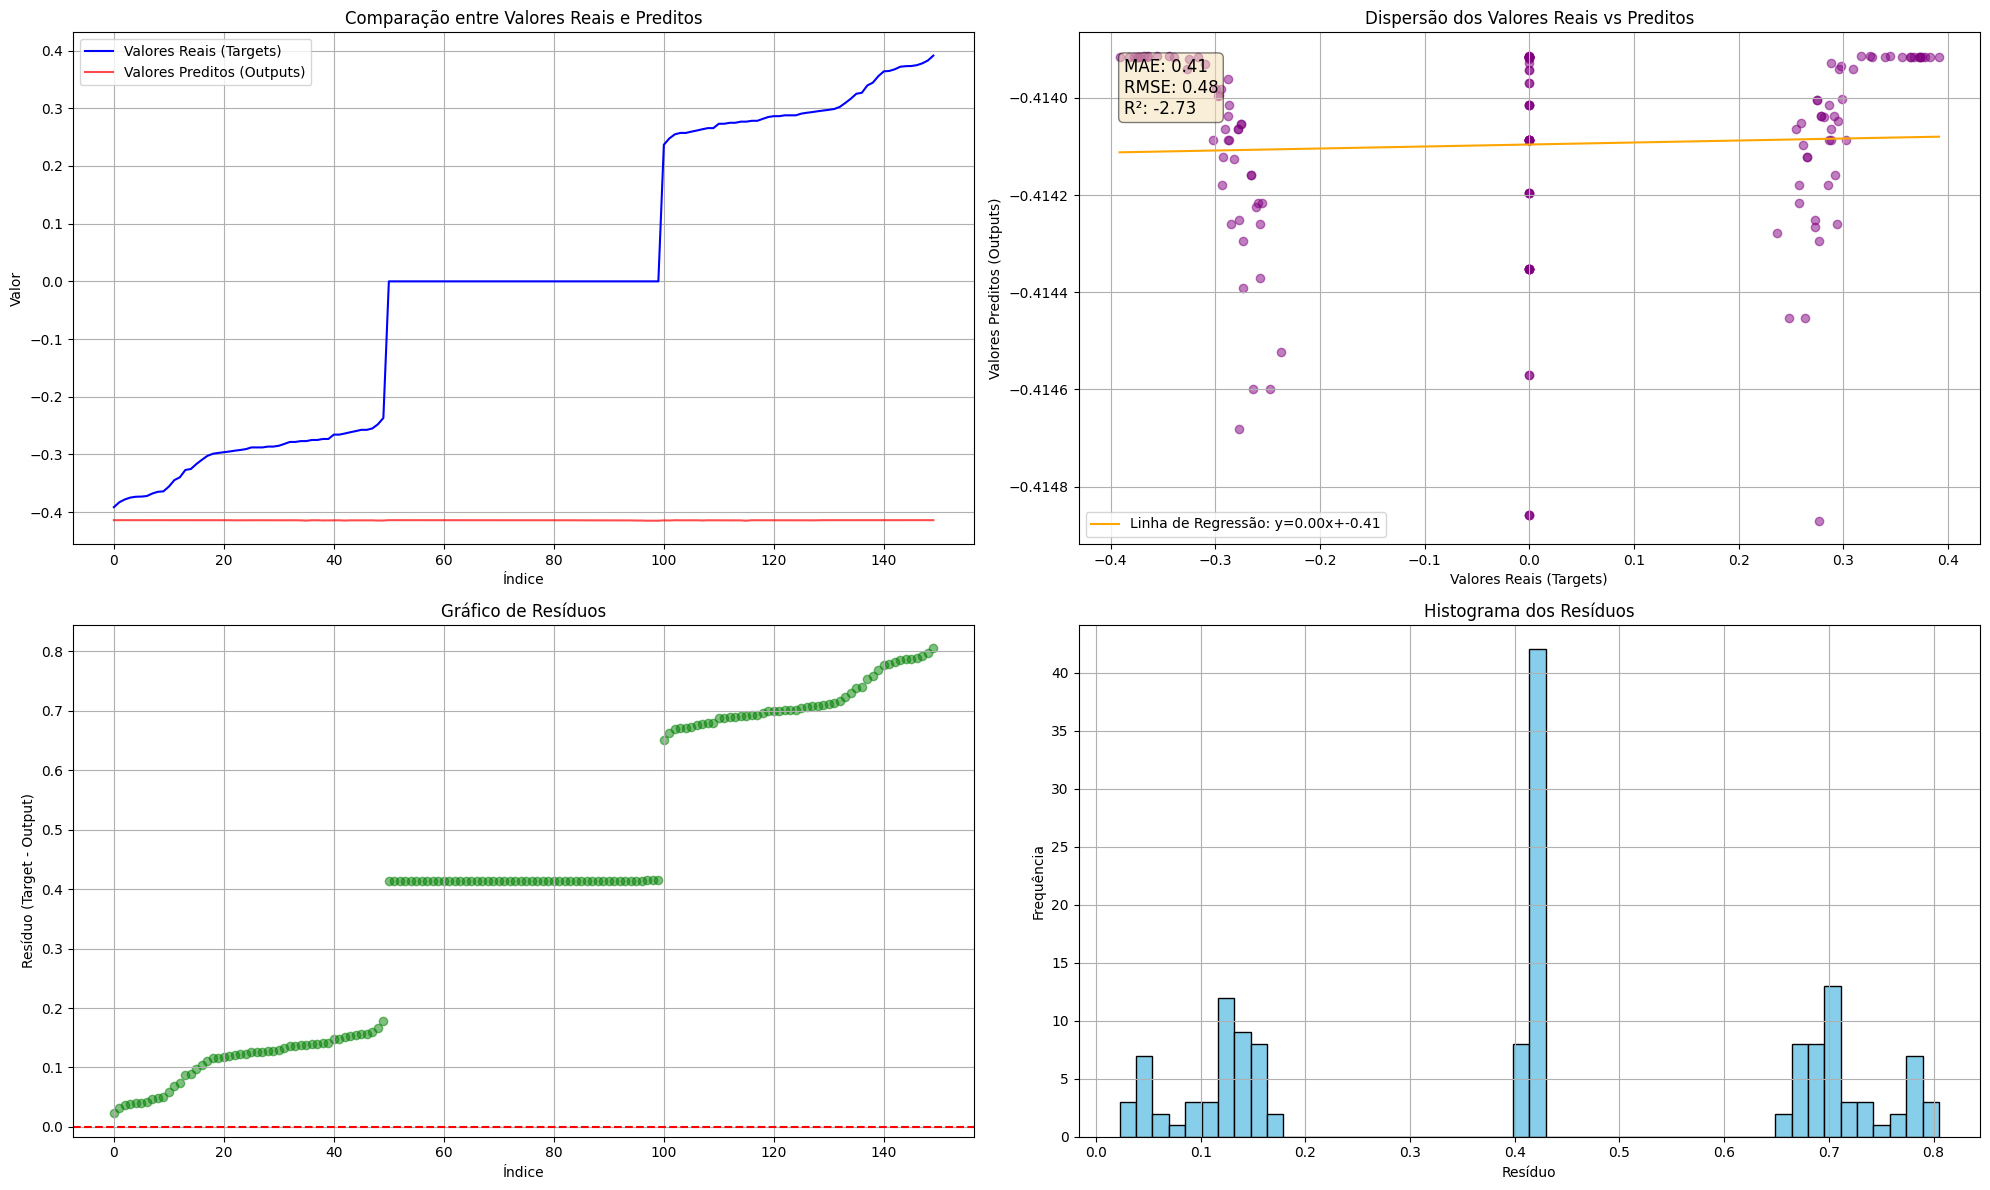

In [21]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Converter DataLoader para iterador
data_iter = iter(validation_dataloader)
# Pegar o primeiro lote
embeddings, lengths, targets = next(data_iter)
print("validation_dataloader", embeddings.shape, lengths.shape, targets.shape)

# Garantir os tipos de dados corretos
embeddings = embeddings.to(torch.float32).to('cuda')
lengths = lengths.to(torch.int64).to('cuda')
targets = targets.to(torch.float32).to('cuda')

model.to('cuda')
model.eval()

# Realizar a previsão
with torch.no_grad():
    output = model(embeddings, lengths)

# Verificar os sinais de output e target usando os limites fornecidos
output_sign = (output <= negative_threshold).float() - (output >= positive_threshold).float()
target_sign = (targets <= negative_threshold).float() - (targets >= positive_threshold).float()

# Calcular as correspondências
matches = (output_sign == target_sign)

# Calcular a precisão média
accuracy = matches.float().mean()
print(f"Acurácia: {accuracy:.4f}")

# Ordenar os targets em ordem crescente e rearranjar os outputs de acordo
sorted_indices = targets.argsort(axis=0).flatten()  # Obter índices que ordenam os targets
targets_sorted = targets[sorted_indices]
output_sorted = output[sorted_indices]

# Aplicar a transformação inversa assinada usando .item()
targets_sorted_transformed = np.array([(t.item()) for t in targets_sorted])
output_sorted_transformed = np.array([(o.item()) for o in output_sorted])

# Calcular métricas de avaliação
mae = mean_absolute_error(targets_sorted_transformed, output_sorted_transformed)
rmse = np.sqrt(mean_squared_error(targets_sorted_transformed, output_sorted_transformed))
r2 = r2_score(targets_sorted_transformed, output_sorted_transformed)

# Criar uma figura com três subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))

# Gráfico 1: Comparação entre Valores Reais e Preditos
axes[0, 0].plot(targets_sorted_transformed, label='Valores Reais (Targets)', color='blue')
axes[0, 0].plot(output_sorted_transformed, label='Valores Preditos (Outputs)', color='red', alpha=0.7)
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Valor')
axes[0, 0].set_title('Comparação entre Valores Reais e Preditos')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Gráfico 2: Gráfico de Dispersão com Linha de Regressão
axes[0, 1].scatter(targets_sorted_transformed, output_sorted_transformed, alpha=0.5, color='purple')
# Linha de regressão
m, b = np.polyfit(targets_sorted_transformed, output_sorted_transformed, 1)
axes[0, 1].plot(targets_sorted_transformed, m * targets_sorted_transformed + b, color='orange', label=f'Linha de Regressão: y={m:.2f}x+{b:.2f}')
axes[0, 1].set_xlabel('Valores Reais (Targets)')
axes[0, 1].set_ylabel('Valores Preditos (Outputs)')
axes[0, 1].set_title('Dispersão dos Valores Reais vs Preditos')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Gráfico 3: Gráfico de Resíduos
residuals = targets_sorted_transformed - output_sorted_transformed
axes[1, 0].scatter(range(len(residuals)), residuals, alpha=0.5, color='green')
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Resíduo (Target - Output)')
axes[1, 0].set_title('Gráfico de Resíduos')
axes[1, 0].grid(True)

# Gráfico 4: Histograma dos Resíduos
axes[1, 1].hist(residuals, bins=50, color='skyblue', edgecolor='black')
axes[1, 1].set_xlabel('Resíduo')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].set_title('Histograma dos Resíduos')
axes[1, 1].grid(True)

# Adicionar métricas no gráfico de dispersão
metrics_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"
axes[0, 1].text(0.05, 0.95, metrics_text, transform=axes[0, 1].transAxes,
               fontsize=12, verticalalignment='top',
               bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

# Ajustar layout para evitar sobreposição
plt.tight_layout()

# Exibir a figura
plt.show()

In [19]:
import torch

# Função de teste da CustomHuberLoss
def test_all_sign_cases():
    # Instanciar a perda customizada
    criterion = CustomHuberLoss(delta=1.0)

    # Exemplo 1: Ambos positivos
    output1 = torch.tensor([2.0])  # Positivo
    target1 = torch.tensor([3.0])  # Positivo
    loss1 = criterion(output1, target1)
    print(f"Loss 2.0 3.0 (ambos positivos): {loss1.item()}")  # Esperado: perda normal

    # Exemplo 2: Ambos negativos
    output2 = torch.tensor([-2.0])  # Negativo
    target2 = torch.tensor([-3.0])  # Negativo
    loss2 = criterion(output2, target2)
    print(f"Loss -2.0 -3.0 (ambos negativos): {loss2.item()}")  # Esperado: perda normal

    # Exemplo 3: Output positivo, target negativo
    output3 = torch.tensor([2.0])  # Positivo
    target3 = torch.tensor([-3.0])  # Negativo
    loss3 = criterion(output3, target3)
    print(f"Loss 2.0 -3.0 (output positivo, target negativo): {loss3.item()}")  # Esperado: perda * 2

    # Exemplo 4: Output negativo, target positivo
    output4 = torch.tensor([-2.0])  # Negativo
    target4 = torch.tensor([3.0])  # Positivo
    loss4 = criterion(output4, target4)
    print(f"Loss -2.0 3.0 (output negativo, target positivo): {loss4.item()}")  # Esperado: perda * 2

    # Exemplo 5: Output dentro do intervalo, target positivo
    output5 = torch.tensor([0.5])  # Dentro do intervalo
    target5 = torch.tensor([2.0])  # Positivo
    loss5 = criterion(output5, target5)
    print(f"Loss 0.5 2.0 (output dentro do intervalo, target positivo): {loss5.item()}")  # Esperado: perda normal

    # Exemplo 6: Output dentro do intervalo, target negativo
    output6 = torch.tensor([-0.5])  # Dentro do intervalo
    target6 = torch.tensor([-2.0])  # Negativo
    loss6 = criterion(output6, target6)
    print(f"Loss -0.5 -2.0 (output dentro do intervalo, target negativo): {loss6.item()}")  # Esperado: perda normal

    # Exemplo 7: Ambos dentro do intervalo, mas sinais diferentes
    output7 = torch.tensor([-0.5])  # Dentro do intervalo, negativo
    target7 = torch.tensor([0.5])  # Dentro do intervalo, positivo
    loss7 = criterion(output7, target7)
    print(f"Loss -0.5 0.5 (sinais diferentes dentro do intervalo): {loss7.item()}")  # Esperado: perda * 2

test_all_sign_cases()

Loss 2.0 3.0 (ambos positivos): 1.0
Loss -2.0 -3.0 (ambos negativos): 1.0
Loss 2.0 -3.0 (output positivo, target negativo): 50.0
Loss -2.0 3.0 (output negativo, target positivo): 50.0
Loss 0.5 2.0 (output dentro do intervalo, target positivo): 2.25
Loss -0.5 -2.0 (output dentro do intervalo, target negativo): 2.25
Loss -0.5 0.5 (sinais diferentes dentro do intervalo): 2.0


In [22]:
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
import torch

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

model.to('cuda')
model.eval()
with torch.no_grad():
	for example in eval_dataset:
		# Tokenização combinada
		encoding = embedding_generator.tokenizer(
			[example['sentence1'], example['sentence2']],
			return_tensors="pt",
			padding=True,  # Padding dinâmico
			truncation=True
		)

		# Converter para o dispositivo
		input_ids1 = encoding['input_ids'][0]
		attention_mask1 = encoding['attention_mask'][0]
		input_ids2 = encoding['input_ids'][1]
		attention_mask2 = encoding['attention_mask'][1]

		# Obter embeddings
		embeddings1 = embedding_generator.weights[input_ids1]
		embeddings2 = embedding_generator.weights[input_ids2]        
		
		# Concatenar as duas sequências no eixo 1
		embeddings = torch.stack([embeddings1, embeddings2]).float().unsqueeze(0).to('cuda')  # (batch_size, 2, seq_length, vector_size)
		
		# Calcular comprimentos
		lengths1 = attention_mask1.sum(dim=0)
		lengths2 = attention_mask2.sum(dim=0)
		lengths = torch.stack([lengths1, lengths2]).float().unsqueeze(0).to('cuda')  # (batch_size, 2)

		# Converter targets
		score = torch.tensor(example['score'], dtype=torch.float16).unsqueeze(0).to('cuda')  # (batch_size,)

		# Obter a previsão do modelo
		prediction = model(embeddings, lengths)
		#output_np = prediction.cpu().numpy().reshape(-1, 1)
		
		pred_score = 1 / (1 + abs(prediction))
		#pred_score = 1 / (1 + abs(inverse_signed_log_transform(output_np.item())))

		# Armazenar as pontuações
		true_scores.append(score.item())
		pred_scores.append(pred_score.item())

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print("Similaridade Inversa da Diferença Absoluta")
print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")

Similaridade Inversa da Diferença Absoluta
Correlação de Pearson: 0.0306
Correlação de Spearman: 0.0394


In [20]:
import torch
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm  # Para acompanhar o progresso
import numpy as np  # Certifique-se de importar o NumPy

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Definir o intervalo de valores de k a serem testados
k_values = np.arange(0.001, 100.0, 0.01)
best_k = None
best_pearson = -1  # Inicialização com um valor baixo
best_spearman = -1

# Pré-computar todas as predições para evitar recalcular múltiplas vezes
true_scores = []
predictions = []

model.to('cuda')
model.eval()
with torch.no_grad():
    for example in tqdm(eval_dataset, desc="Processando exemplos"):
        # Tokenização combinada
        encoding = embedding_generator.tokenizer(
            [example['sentence1'], example['sentence2']],
            return_tensors="pt",
            padding=True,  # Padding dinâmico
            truncation=True
        )

        # Converter para o dispositivo
        input_ids1 = encoding['input_ids'][0]
        attention_mask1 = encoding['attention_mask'][0]
        input_ids2 = encoding['input_ids'][1]
        attention_mask2 = encoding['attention_mask'][1]

        # Obter embeddings
        embeddings1 = embedding_generator.weights[input_ids1]
        embeddings2 = embedding_generator.weights[input_ids2]        
        
        # Concatenar as duas sequências no eixo 1
        embeddings = torch.stack([embeddings1, embeddings2]).float().unsqueeze(0).to('cuda')  # (batch_size, 2, seq_length, vector_size)
        
        # Calcular comprimentos
        lengths1 = attention_mask1.sum(dim=0)
        lengths2 = attention_mask2.sum(dim=0)
        lengths = torch.stack([lengths1, lengths2]).float().unsqueeze(0).to('cuda')  # (batch_size, 2)

        # Converter targets
        score = torch.tensor(example['score'], dtype=torch.float16).unsqueeze(0).to('cuda')  # (batch_size,)

        # Obter a previsão do modelo
        prediction = model(embeddings, lengths)
        predictions.append(prediction.item())

        # Armazenar as pontuações reais como valores escalares
        true_scores.append(score.item())

true_scores = np.array(true_scores)  # Agora é um array 1D
predictions = np.array(predictions)

# Iterar sobre os valores de k para encontrar o melhor
for k in tqdm(k_values, desc="Buscando o melhor k"):
    pred_scores = np.exp(-k * np.abs(predictions))
    
    pearson_corr, _ = pearsonr(true_scores, pred_scores)
    spearman_corr, _ = spearmanr(true_scores, pred_scores)
    
    # Verificar se este k é o melhor até agora
    if pearson_corr > best_pearson:
        best_pearson = pearson_corr
        best_spearman = spearman_corr
        best_k = k

print("Similaridade Baseada em Exponencial")
print(f"Melhor valor de k: {best_k}")
print(f"Correlação de Pearson: {best_pearson:.4f}")
print(f"Correlação de Spearman: {best_spearman:.4f}")

Buscando o melhor k: 100%|██████████| 10000/10000 [00:17<00:00, 555.90it/s]

Similaridade Baseada em Exponencial
Melhor valor de k: 0.001
Correlação de Pearson: 0.0345
Correlação de Spearman: 0.0227


In [ ]:
import os
import torch
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
from scipy.stats import pearsonr, spearmanr

# Verificar se CUDA está disponível
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Carregar o modelo SentenceTransformer
model = SentenceTransformer("all-mpnet-base-v2").to(device)

# Carregar o conjunto de dados de avaliação (STS Benchmark)
eval_dataset = load_dataset("sentence-transformers/stsb", split="validation")

# Listas para armazenar as pontuações reais e as previsões do modelo
true_scores = []
pred_scores = []

# Obter as sentenças e os escores do conjunto de dados
sentences1 = eval_dataset['sentence1']
sentences2 = eval_dataset['sentence2']
scores = eval_dataset['score']

# Processar uma frase por vez
for i in range(len(eval_dataset)):
    sentence1 = sentences1[i]
    sentence2 = sentences2[i]
    true_score = scores[i]

    # Gerar embeddings para ambas as sentenças individualmente
    embedding1 = model.encode(sentence1, convert_to_tensor=True, device=device, show_progress_bar=False)
    embedding2 = model.encode(sentence2, convert_to_tensor=True, device=device, show_progress_bar=False)

    # Calcular a similaridade cosseno
    cosine_score = util.cos_sim(embedding1, embedding2).item()

    # Escalar a similaridade cosseno de [-1, 1] para [0, 1]
    scaled_score = (cosine_score + 1) / 2

    # Armazenar as pontuações
    true_scores.append(true_score)
    pred_scores.append(scaled_score)

# Calcular as métricas de correlação
pearson_corr, _ = pearsonr(true_scores, pred_scores)
spearman_corr, _ = spearmanr(true_scores, pred_scores)

print(f"Correlação de Pearson: {pearson_corr:.4f}")
print(f"Correlação de Spearman: {spearman_corr:.4f}")